In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from stellargraph import datasets
from IPython.display import display, HTML

In [2]:
# retrieving data and putting into pandas dataframe
cs_cites = pd.read_csv(
    '../data/citeseer.cites.csv',
    # sep="\t",
    # header=None,
    names=["target", "source"],
    ) # no column unique
cs_cites = cs_cites.drop(0)
# for index, row in cs_cites.iterrows():
#     try:
#         row['target'] = int(row['target'])
#         row['source'] = int(row['source'])
#     except:
#         continue

# # create a Boolean mask for the rows to remove
# mask = cs_cites['source'] == 'ghani01hypertext' | cs_cites['source'] == 'nielsen00designing'

# select all rows except the ones that contain 'Coca Cola'
# cs_cites = cs_cites[~cs_cites['source'] == 'ghani01hypertext']
# cs_cites = cs_cites[~cs_cites['source'] == 'nielsen00designing']

cs_cites['target'] = cs_cites['target'].astype(str)
cs_cites['source'] = cs_cites['source'].astype(str)
print(cs_cites.shape)
print(cs_cites.head())

(4732, 2)
   target                  source
1  100157                  100157
2  100157                  364207
3  100157                   38848
4  100157  bradshaw97introduction
5  100157    bylund99coordinating


In [3]:
column_names = ["paper_id"] + ["subject"] + [f"word{idx}" for idx in range(1,3704)]
cs_paper = pd.read_csv(
    '../data/citeseer.paper.csv',
    # sep="\t",
    # header=None,
    names=column_names,
    ) # unique paper id
cs_paper = cs_paper.drop(0) # csv header is automatically formatted to the first row when setting custom column names, so remove
# for index, row in cs_paper.iterrows():
#     try:
#         row['paper_id'] = int(row['paper_id'])
#     except:
#         continue
cs_paper['paper_id'] = cs_paper['paper_id'].astype(str)

cond = ~cs_cites['source'].isin(cs_paper['paper_id'])
cs_cites.drop(cs_cites[cond].index, inplace = True)
cond = ~cs_cites['target'].isin(cs_paper['paper_id'])
cs_cites.drop(cs_cites[cond].index, inplace = True)

# cs_paper['paper_id'] = cs_paper['paper_id'].apply(pd.to_string) # data is not automatically the same data type, so fix
cs_paper = cs_paper.set_index('paper_id') # set index as paper_id for easier data formatting; can change back later
print(cs_paper.head())
print(cs_paper.shape)


c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


         subject  word1  word2  word3  word4  word5  word6  word7  word8  \
paper_id                                                                   
100157    Agents    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
100598        IR    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
101570        ML    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
10227         ML    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
102637        AI    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

          word9  ...  word3694  word3695  word3696  word3697  word3698  \
paper_id         ...                                                     
100157      NaN  ...       NaN       NaN       NaN       NaN       NaN   
100598      NaN  ...       NaN       NaN       NaN       NaN       NaN   
101570      NaN  ...       NaN       NaN       NaN       NaN       NaN   
10227       NaN  ...       NaN       NaN       NaN       NaN       NaN   
102637      NaN  ...   

In [4]:
cs_content = pd.read_csv(
    '../data/citeseer.content.csv',
    # sep="\t",
    # header=None
    ) # no column unique
# for index, row in cs_content.iterrows():
#     try:
#         row['paper_id'] = int(row['paper_id'])
#     except:
#         continue
# cs_content['paper_id'] = cs_content['paper_id'].astype(str)
print(cs_content.head())
print(cs_content.shape)


# numWord = set()
# for word in cs_content['word_cited_id']:
#     numWord.add(int(word[4:]))
# print(min(numWord))

  paper_id word_cited_id
0   100157      word1163
1   100157      word1509
2   100157      word1614
3   100157      word1642
4   100157      word1663
(105165, 2)


In [5]:
for i in range(1, 3704): # initialize all word columns to zero - manual one hot encoding
    name = "word"+str(i)
    cs_paper[name] = 0
print(cs_paper.head())
print(cs_paper.shape)

         subject  word1  word2  word3  word4  word5  word6  word7  word8  \
paper_id                                                                   
100157    Agents      0      0      0      0      0      0      0      0   
100598        IR      0      0      0      0      0      0      0      0   
101570        ML      0      0      0      0      0      0      0      0   
10227         ML      0      0      0      0      0      0      0      0   
102637        AI      0      0      0      0      0      0      0      0   

          word9  ...  word3694  word3695  word3696  word3697  word3698  \
paper_id         ...                                                     
100157        0  ...         0         0         0         0         0   
100598        0  ...         0         0         0         0         0   
101570        0  ...         0         0         0         0         0   
10227         0  ...         0         0         0         0         0   
102637        0  ...   

In [6]:
for index, row in cs_content.iterrows(): # mark as true for words used by each paper
    try:
        cs_paper.at[str(row['paper_id']), str(row['word_cited_id'])] = 1
    except ValueError:
        cs_paper.at[str(row['paper_id']), str(row['word_cited_id'])] = 1
    # if len(cs_paper['subject']) != 3312:
    #     print(row['paper_id'])

cs_paper = cs_paper.reset_index()
print(cs_paper.shape)
print(cs_paper.sample(5))

(3312, 3705)
                     paper_id subject  word1  word2  word3  word4  word5  \
364                    323955      ML      0      0      0      0      0   
1739     fischer96intelligent  Agents      0      0      0      0      0   
125                    196348      DB      0      0      0      0      0   
2052        jennings01aspects     HCI      0      0      0      0      0   
3142  vonhardenberg01barehand     HCI      0      0      0      0      0   

      word6  word7  word8  ...  word3694  word3695  word3696  word3697  \
364       0      0      0  ...         0         0         0         0   
1739      0      0      0  ...         0         0         0         0   
125       0      0      0  ...         0         0         0         0   
2052      0      0      0  ...         0         0         0         0   
3142      0      0      0  ...         0         0         0         0   

      word3698  word3699  word3700  word3701  word3702  word3703  
364          0    

In [7]:
class_values = sorted(cs_paper["subject"].unique()) # one hot encoding of rest of variables
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(cs_paper["paper_id"].unique()))}

cs_paper["paper_id"] = cs_paper["paper_id"].apply(lambda name: paper_idx[name])
cs_cites["source"] = cs_cites["source"].apply(lambda name: paper_idx[name])
cs_cites["target"] = cs_cites["target"].apply(lambda name: paper_idx[name])
cs_paper["subject"] = cs_paper["subject"].apply(lambda value: class_idx[value])


In [9]:
print(cs_cites.columns)

Index(['target', 'source'], dtype='object')


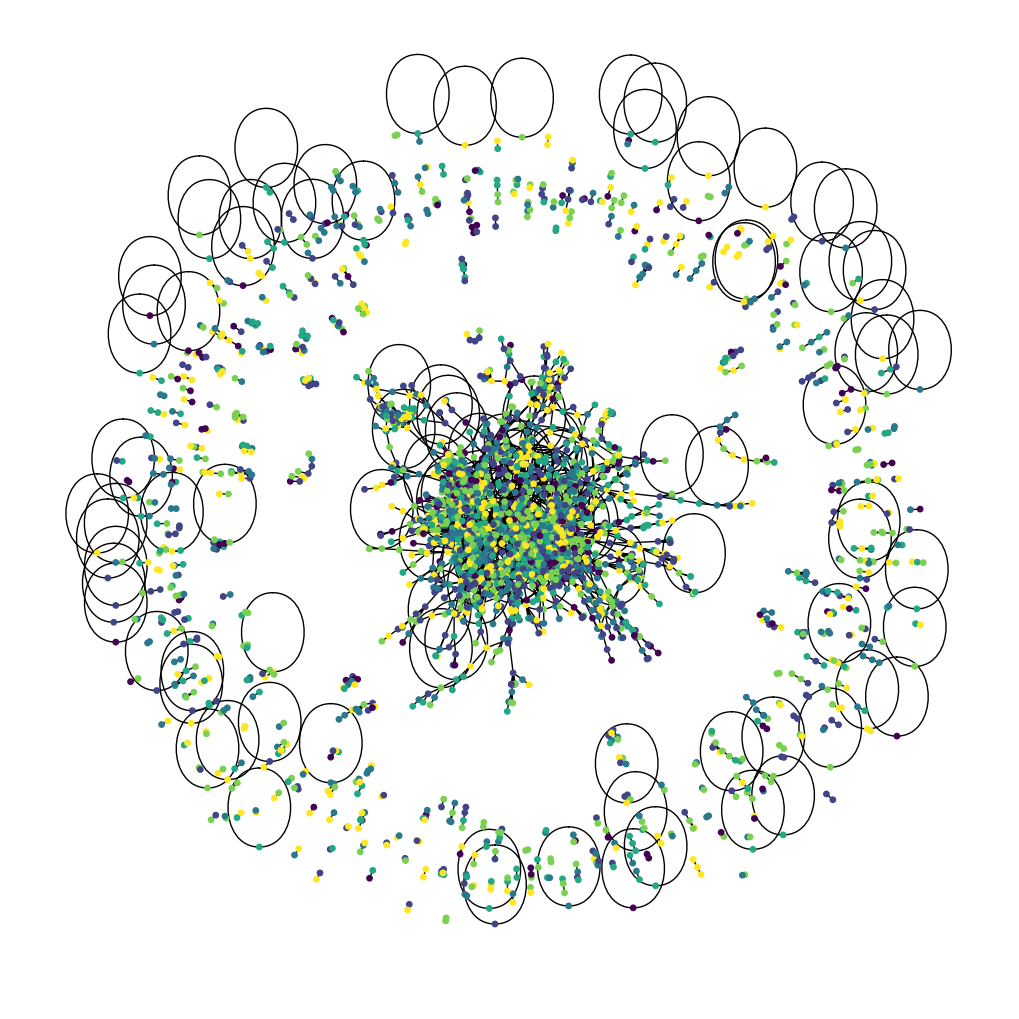

In [12]:
plt.figure(figsize=(10, 10))
colors = cs_paper["subject"].tolist()
citeseer_graph = nx.from_pandas_edgelist(cs_cites)# cs_cites.sample(n=1500))
subjects = list(cs_paper[cs_paper["paper_id"].isin(list(citeseer_graph.nodes))]["subject"])
nx.draw_spring(citeseer_graph, node_size=15, node_color=subjects)

In [128]:
train_data, test_data = [], []

for _, group_data in cs_paper.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (2675, 3705)
Test data shape: (637, 3705)


In [129]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [130]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="lower right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)



In [131]:
feature_names = set(cs_paper.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]


In [132]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 3703)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           134524      ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [133]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/300
9/9 [==============================] - 5s 106ms/step - loss: 3.2050 - acc: 0.1927 - val_loss: 1.7558 - val_acc: 0.2015
Epoch 2/300
9/9 [==============================] - 0s 37ms/step - loss: 2.2364 - acc: 0.2336 - val_loss: 1.7567 - val_acc: 0.2164
Epoch 3/300
9/9 [==============================] - 0s 36ms/step - loss: 1.9942 - acc: 0.2516 - val_loss: 1.7789 - val_acc: 0.2488
Epoch 4/300
9/9 [==============================] - 0s 37ms/step - loss: 1.7975 - acc: 0.2908 - val_loss: 1.7028 - val_acc: 0.2985
Epoch 5/300
9/9 [==============================] - 0s 35ms/step - loss: 1.6508 - acc: 0.3379 - val_loss: 1.6470 - val_acc: 0.2836
Epoch 6/300
9/9 [==============================] - 0s 37ms/step - loss: 1.5338 - acc: 0.4026 - val_loss: 1.5973 - val_acc: 0.3035
Epoch 7/300
9/9 [==============================] - 0s 37ms/step - loss: 1.3890 - acc: 0.4619 - val_loss: 1.5030 - val_acc: 0.3955
Epoch 8/300
9/9 [==============================] - 0s 38ms/step - loss: 1.2645 - acc: 0.5

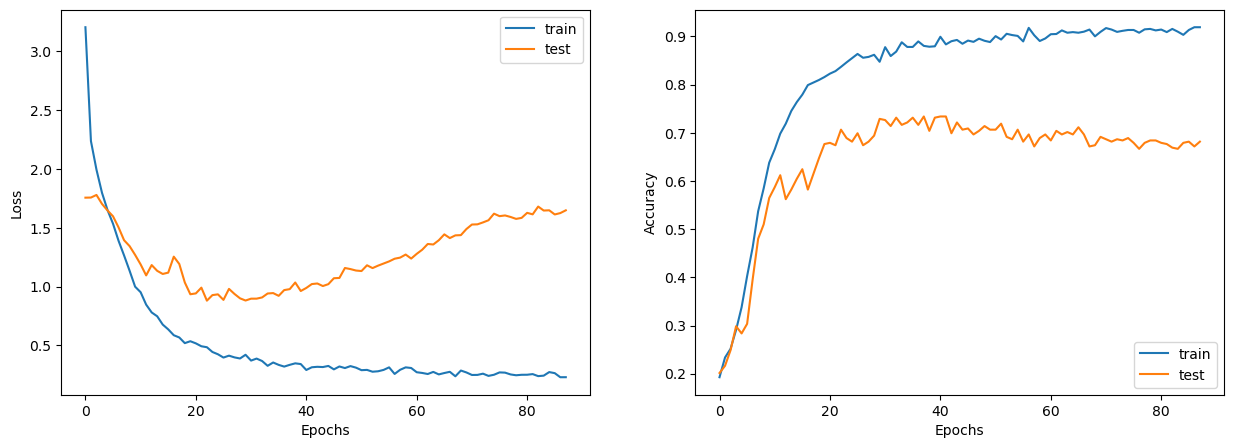

In [134]:
display_learning_curves(history)


In [135]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 71.43%


In [136]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [137]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)


1/1 [==============================] - 1s 569ms/step
Instance 1:
- AI: 1.11%
- Agents: 2.95%
- DB: 92.47%
- HCI: 2.02%
- IR: 0.27%
- ML: 1.19%
Instance 2:
- AI: 0.67%
- Agents: 2.9%
- DB: 1.23%
- HCI: 1.81%
- IR: 12.12%
- ML: 81.28%
Instance 3:
- AI: 5.92%
- Agents: 6.58%
- DB: 66.44%
- HCI: 2.98%
- IR: 2.79%
- ML: 15.29%
Instance 4:
- AI: 4.75%
- Agents: 27.1%
- DB: 39.86%
- HCI: 3.85%
- IR: 3.55%
- ML: 20.89%
Instance 5:
- AI: 0.79%
- Agents: 15.74%
- DB: 70.7%
- HCI: 1.92%
- IR: 0.86%
- ML: 9.99%
Instance 6:
- AI: 1.61%
- Agents: 24.63%
- DB: 19.93%
- HCI: 37.88%
- IR: 4.76%
- ML: 11.2%


In [138]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = cs_cites[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    cs_paper.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)


Edges shape: (2, 4715)
Nodes shape: (3312, 3703)


In [139]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [140]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [141]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()


GNN output shape: tf.Tensor(
[[-0.03654686  0.06210609  0.07647496  0.02303214 -0.00646152  0.21468653]
 [-0.09067066  0.00789476  0.02124342  0.14306696 -0.03452162  0.12828082]
 [-0.05334935 -0.0414196  -0.05630224 -0.01562309 -0.00311995 -0.07066217]], shape=(3, 6), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (3312, 32)                134524    
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (3312, 

In [142]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)


Epoch 1/300
9/9 [==============================] - 8s 326ms/step - loss: 1.9617 - acc: 0.1905 - val_loss: 1.7702 - val_acc: 0.1940
Epoch 2/300
9/9 [==============================] - 2s 215ms/step - loss: 1.8321 - acc: 0.2019 - val_loss: 1.7635 - val_acc: 0.1940
Epoch 3/300
9/9 [==============================] - 2s 218ms/step - loss: 1.7916 - acc: 0.2059 - val_loss: 1.7606 - val_acc: 0.2313
Epoch 4/300
9/9 [==============================] - 2s 219ms/step - loss: 1.7686 - acc: 0.2138 - val_loss: 1.7552 - val_acc: 0.1965
Epoch 5/300
9/9 [==============================] - 2s 218ms/step - loss: 1.7601 - acc: 0.2182 - val_loss: 1.7474 - val_acc: 0.2214
Epoch 6/300
9/9 [==============================] - 2s 218ms/step - loss: 1.7288 - acc: 0.2257 - val_loss: 1.7364 - val_acc: 0.2363
Epoch 7/300
9/9 [==============================] - 2s 227ms/step - loss: 1.7103 - acc: 0.2653 - val_loss: 1.7154 - val_acc: 0.2985
Epoch 8/300
9/9 [==============================] - 2s 218ms/step - loss: 1.6610 - a

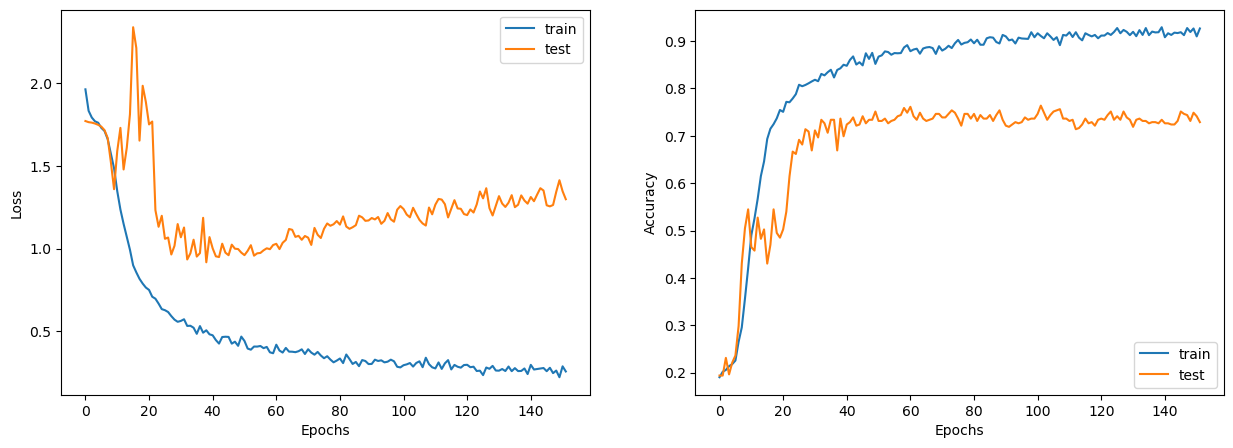

In [143]:
display_learning_curves(history)

In [144]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


Test accuracy: 74.1%


In [146]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in cs_paper.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(cs_paper.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)


In [147]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)


Original node_features shape: (3312, 3703)
Original edges shape: (2, 4715)
New node_features shape: (3318, 3703)
New edges shape: (2, 4757)
1/1 [==============================] - 5s 5s/step
Instance 1:
- AI: 0.23%
- Agents: 0.04%
- DB: 99.29%
- HCI: 0.02%
- IR: 0.29%
- ML: 0.13%
Instance 2:
- AI: 2.69%
- Agents: 6.81%
- DB: 2.89%
- HCI: 6.48%
- IR: 73.67%
- ML: 7.45%
Instance 3:
- AI: 4.02%
- Agents: 19.3%
- DB: 58.39%
- HCI: 1.29%
- IR: 1.41%
- ML: 15.6%
Instance 4:
- AI: 6.27%
- Agents: 25.26%
- DB: 10.91%
- HCI: 35.33%
- IR: 7.61%
- ML: 14.62%
Instance 5:
- AI: 0.31%
- Agents: 0.21%
- DB: 96.59%
- HCI: 0.15%
- IR: 2.49%
- ML: 0.26%
Instance 6:
- AI: 2.38%
- Agents: 71.57%
- DB: 3.62%
- HCI: 3.58%
- IR: 9.81%
- ML: 9.03%
